In [1]:
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn.functional as F
from torch import Tensor, nn
from torchsummary import summary
from torchvision.transforms import Compose, Resize, ToTensor

from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

from IPython.display import Image as IPython_Image

### load image and prep ###

In [4]:
img = Image.open('penguin.jpg')
# fig = plt.figure()
# plt.imshow(img)
# plt.show()

In [62]:
transform = Compose([
    Resize((224, 224)),
    ToTensor(),
])

org_x = transform(img)
x = org_x.unsqueeze(0)
print(org_x.shape)
print(x.shape)


torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


### patch embedding ###

In [86]:
class PatchEmbedding(nn.Module):
    def __init__(self, 
                 in_channels: int = 3, 
                 patch_size: int = 16, 
                 emb_size: int = 768): # latent D's dimension
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
                                nn.Conv2d(in_channels, 
                                          emb_size, 
                                          kernel_size=patch_size, 
                                          stride=patch_size),
                                Rearrange('b e (h) (w) -> b (h w) e'),
                                ) 
        # b e (h) (w) -> b (h w) e : 
        #     batch  embedding_size  height  width
        #     batch  height          width   embedding_size
        # this breaks down the image in s1xs2 patches, and then flat them
        
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))
        
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        # x is equal to patch embeddings
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        x = torch.cat([cls_tokens, x], dim=1) #prepending the class token
        x += self.positions
        return x    


### shape confirmation ###

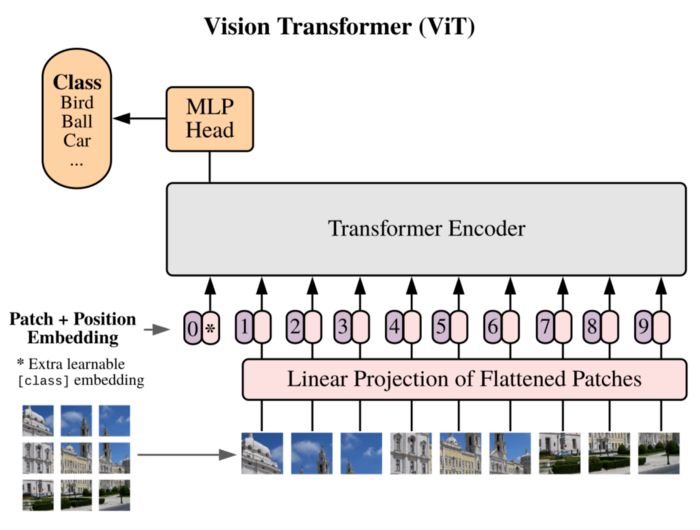

In [89]:
IPython_Image(filename = 'vit.png', width=400, height=200)

In [68]:
pe_obj = PatchEmbedding()
print(pe_obj.projection)
print(f'PatchEmbedding shape results : {pe_obj(x).shape}')

img_size=224; patch_size=16
positions = nn.Parameter(torch.randn((img_size// patch_size) **2 + 1, emb_size))
print(f'positions : {positions.shape}')

cls_token = nn.Parameter(torch.randn(1,1, emb_size))
print(f'cls_token : {cls_token.shape}')

# PatchEmbedding.projection을 거쳐서 나온 결과가 196 * 768
# + learnable [class] embedding -> 197 * 768

Sequential(
  (0): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (1): Rearrange('b e (h) (w) -> b (h w) e')
)
PatchEmbedding shape results : torch.Size([1, 196, 768])
positions : torch.Size([197, 768])
cls_token : torch.Size([1, 1, 768])


##### output of class #####

In [96]:
org_x = transform(img)
x = org_x.unsqueeze(0)

pe_obj = PatchEmbedding()
print(pe_obj.projection)
res = pe_obj(x)
print(f'PatchEmbedding shape results : {res.shape}')

Sequential(
  (0): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (1): Rearrange('b e (h) (w) -> b (h w) e')
)
PatchEmbedding shape results : torch.Size([1, 197, 768])


In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.qkv = nn.Linear(emb_size, emb_size * 3) # queries, keys and values matrix
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        out = torch.einsum('bhal, bhlv -> bhav ', att, values) # sum over the third axis
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        
        return out

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self,
                 emb_size: int = 768,
                 num_heads: int = 8,
                 dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        if self.emb_size % self.num_heads != 0:
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (self.emb_size, self.num_heads))        
        
        '''
        self.qkv = nn.Linear(emb_size, 
                             emb_size * 3) 
                             # queries, keys and values matrix
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, 
                                    emb_size)
        '''
        self.attention_head_size = int(self.emb_size / self.num_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(self.emb_size, self.all_head_size)
        self.key = nn.Linear(self.emb_size, self.all_head_size)
        self.value = nn.Linear(self.emb_size, self.all_head_size)

        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(self.emb_size, self.all_head_size)

    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), 
                        "b n (h d qkv) -> (qkv) b h n d", 
                        h=self.num_heads, 
                        qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        
        self.query = nn.Linear(hidden_size, self.all_head_size)
        self.key = nn.Linear(hidden_size, self.all_head_size)
        self.value = nn.Linear(hidden_size, self.all_head_size)
        
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        out = torch.einsum('bhal, bhlv -> bhav ', att, values) # sum over the third axis
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        
        return out
    

### class confirm ###

In [19]:
pe_obj = PatchEmbedding()
print(pe_obj(x).shape)
print(pe_obj.projection)

torch.Size([1, 196, 768])
Sequential(
  (0): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (1): Rearrange('b e (h) (w) -> b (h w) e')
)


### test ###

In [26]:
from einops import rearrange, reduce, repeat

transform = Compose([
    Resize((224, 224)),
    ToTensor(),
])

org_x = transform(img)
x = org_x.unsqueeze(0)
print(org_x.shape)
print(x.shape)
in_channels: int = 3
patch_size: int = 16
emb_size: int = 768
conv_obj = nn.Conv2d(in_channels,
                     emb_size,
                     kernel_size=patch_size,
                     stride=patch_size)
print(x.shape)
x = conv_obj(x)
print(x.shape)
# Rearrange(x, 'b e (h) (w) -> b (h w) e') # 클래스
rearrange(x, 'b e (h) (w) -> b (h w) e')   # 함수

print(x.shape)



torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 768, 14, 14])
torch.Size([1, 768, 14, 14])


In [8]:
config = ViTConfig(num_hidden_layer=12, hiddem_size=768)
model = ViTForImageClassification(config)


In [9]:
print(config)

ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hiddem_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layer": 12,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.26.0"
}



In [10]:
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")


In [11]:
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224",
                                                  revision="db75733ce9ead4ed3dce26ab87a6ed2f6f565985")


In [4]:
from transformers import ViTFeatureExtractor
feature_extractor = ViTFeatureExtractor()
# feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")


2023-02-13 09:29:30.655754: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
/home/dl-server/anaconda3/envs/development/lib/python3.7/site-packages/transformers/models/vit/feature_extraction_vit.py:31: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  FutureWarning,


In [18]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [2]:
from PIL import Image
import requests

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image.save("cats.png")


In [3]:
# prepare for the model
inputs = feature_extractor(image, return_tensors="pt")
pixel_values = inputs.pixel_values
print(pixel_values.shape)

NameError: name 'feature_extractor' is not defined

In [ ]:
# forward pass
outputs = model(pixel_values)
logits = outputs.logits

In [ ]:
print("predicted class idx  : ", logits.argmax(-1).item())
print("predicted class name : ",model.config.id2label[logits.argmax(-1).item()])


### pipeline (only inference) ###

In [38]:
from transformers import pipeline
image_pipe = pipeline("image-classification")

No model was supplied, defaulted to google/vit-base-patch16-224 and revision 5dca96d (https://huggingface.co/google/vit-base-patch16-224).
Using a pipeline without specifying a model name and revision in production is not recommended.
/home/dl-server/anaconda3/envs/development/lib/python3.7/site-packages/transformers/models/vit/feature_extraction_vit.py:31: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  FutureWarning,


In [39]:
image_pipe(image)

[{'score': 0.9374411702156067, 'label': 'Egyptian cat'},
 {'score': 0.03844274580478668, 'label': 'tabby, tabby cat'},
 {'score': 0.014411410316824913, 'label': 'tiger cat'},
 {'score': 0.0032743273768574, 'label': 'lynx, catamount'},
 {'score': 0.0006795928347855806, 'label': 'Siamese cat, Siamese'}]

In [45]:
# load a ConvNext model
from transformers import AutoFeatureExtractor, AutoModelForImageClassification

feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/convnext-tiny-224")
model = AutoModelForImageClassification.from_pretrained("facebook/convnext-tiny-224")


In [48]:
image_pipe = pipeline("image-classification",
             model=model,
             feature_extractor=feature_extractor)

In [49]:
image_pipe(image)

[{'score': 0.6132751107215881, 'label': 'tabby, tabby cat'},
 {'score': 0.27366378903388977, 'label': 'tiger cat'},
 {'score': 0.00957531575113535, 'label': 'Egyptian cat'},
 {'score': 0.0017712308326736093, 'label': 'quilt, comforter, comfort, puff'},
 {'score': 0.0017434785841032863, 'label': 'pillow'}]

In [50]:
object_detection_pipe = pipeline("object-detection")

No model was supplied, defaulted to facebook/detr-resnet-50 and revision 2729413 (https://huggingface.co/facebook/detr-resnet-50).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /home/dl-server/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth


/home/dl-server/anaconda3/envs/development/lib/python3.7/site-packages/transformers/models/detr/feature_extraction_detr.py:31: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  FutureWarning,
/home/dl-server/anaconda3/envs/development/lib/python3.7/site-packages/transformers/models/detr/image_processing_detr.py:779: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  FutureWarning,
/home/dl-server/anaconda3/envs/development/lib/python3.7/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._

In [51]:
results = object_detection_pipe(image)
results

[{'score': 0.9982202649116516,
  'label': 'remote',
  'box': {'xmin': 40, 'ymin': 70, 'xmax': 175, 'ymax': 117}},
 {'score': 0.9960021376609802,
  'label': 'remote',
  'box': {'xmin': 333, 'ymin': 72, 'xmax': 368, 'ymax': 187}},
 {'score': 0.9954743981361389,
  'label': 'couch',
  'box': {'xmin': 0, 'ymin': 1, 'xmax': 639, 'ymax': 473}},
 {'score': 0.99880051612854,
  'label': 'cat',
  'box': {'xmin': 13, 'ymin': 52, 'xmax': 314, 'ymax': 470}},
 {'score': 0.9986783862113953,
  'label': 'cat',
  'box': {'xmin': 345, 'ymin': 23, 'xmax': 640, 'ymax': 368}}]

In [58]:
results[0]['box']

{'xmin': 40, 'ymin': 70, 'xmax': 175, 'ymax': 117}

In [66]:
colors = COLORS * 100
for result, color in zip(results, colors):
    box = result['box']
    print(box)


{'xmin': 40, 'ymin': 70, 'xmax': 175, 'ymax': 117}
{'xmin': 333, 'ymin': 72, 'xmax': 368, 'ymax': 187}
{'xmin': 0, 'ymin': 1, 'xmax': 639, 'ymax': 473}
{'xmin': 13, 'ymin': 52, 'xmax': 314, 'ymax': 470}
{'xmin': 345, 'ymin': 23, 'xmax': 640, 'ymax': 368}


In [114]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], 
          [0.850, 0.325, 0.098],
          [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556],
          [0.466, 0.674, 0.188]]

def plot_results(image, results):
    plt.figure(figsize=(16,10))
    plt.imshow(image)
    ax = plt.gca()
    colors = COLORS * 100
    for result, color in zip(results, colors):
        # print(result)
        # print(color)
        box = result['box']
        xmin, xmax, ymin, ymax = box['xmin'], box['xmax'], box['ymin'], box['ymax']
        label = result['label']
        prob = result['score']        
        ax.add_patch(plt.Rectangle((xmin, ymin), 
                                   xmax - xmin, 
                                   ymax - ymin, 
                                   # file=False, 
                                   fill=False,
                                   color=color, 
                                   linewidth=3))
        text = f'{label}: {prob}'
        print(prob)
        ax.text(xmin, 
                ymin, 
                text, 
                fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()        

0.9982202649116516
0.9960021376609802
0.9954743981361389
0.99880051612854
0.9986783862113953


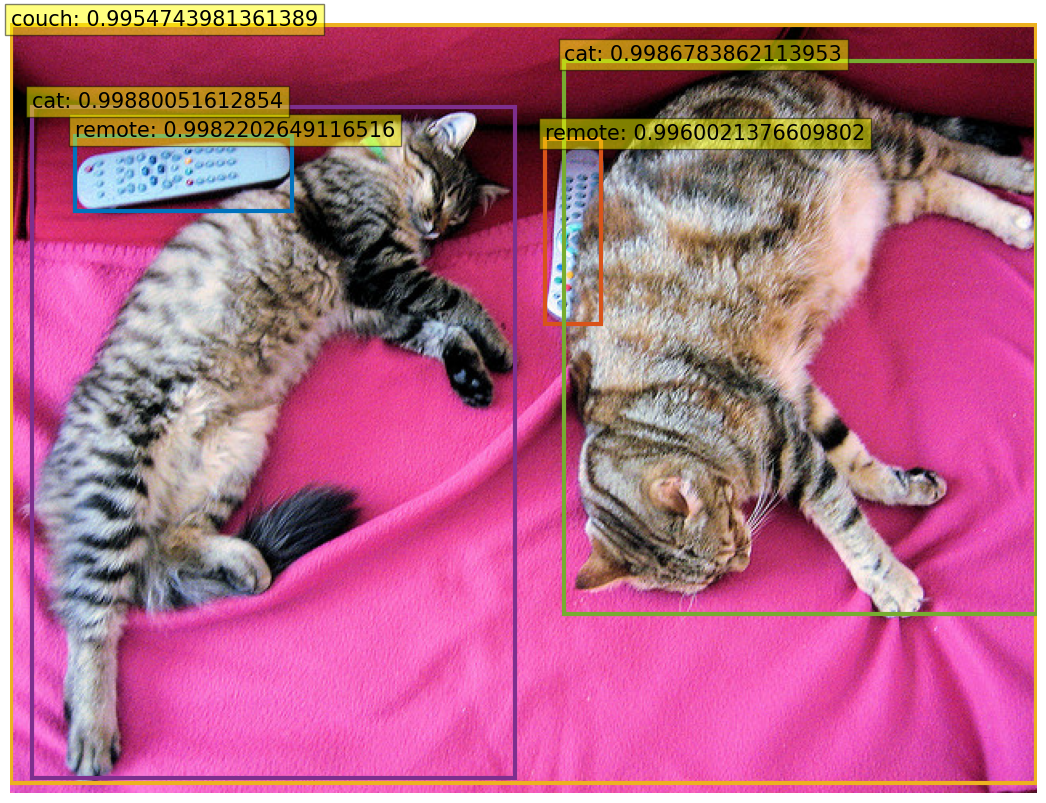

In [115]:
plot_results(image, results)